Create auxilary functions for data generation.

In [47]:
import PolynomialRoots.roots
using Distributions
using Plots

function generate_coefficients(order::Int)
    stable = false
    true_a = []
    # Keep generating coefficients until we come across a set of coefficients
    # that correspond to stable poles
    while !stable
        true_a = randn(order)
        coefs =  append!([1.0], -true_a)
        if false in ([abs(root) for root in roots(coefs)] .> 1)
            continue
        else
            stable = true
        end
    end
    return true_a
end

function generateAR(num::Int, order::Int; nvar=1, stat=true, coefs=nothing)
    if isnothing(coefs) && stat
        coefs = generate_coefficients(order)
    else
        coefs = randn(order)
    end
    inits = randn(order)
    data = Vector{Vector{Float64}}(undef, num+3*order)
    data[1] = inits
    for i in 2:num+3*order
        data[i] = insert!(data[i-1][1:end-1], 1, rand(Distributions.Normal(coefs'data[i-1], sqrt(nvar[])), 1)[1])
    end
    data = data[1+3*order:end]
    return coefs, data
end

generateAR (generic function with 1 method)

In [490]:
using Random
Random.seed!(42)

n_datasets = 100
n_samples = 100
AR_z = 4:8
AR_x = 1:4
noise_var = [1.0, 0.3, 0.1]
SNR_s = rand(noise_var, n_datasets)
speech_data, noise_data = [generateAR(100, rand(AR_z)) for _ in 1:n_datasets], [generateAR(100, rand(AR_x), nvar=SNR_s[i]) for i in 1:n_datasets];

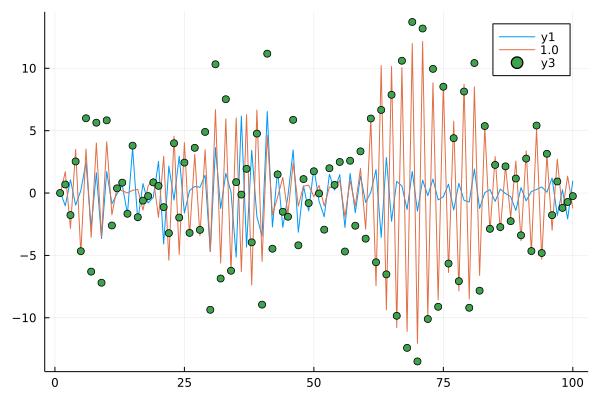

In [491]:
plot(first.(speech_data[20][2]))
plot!(first.(noise_data[20][2]), label=SNR_s[20])
output = first.(speech_data[20][2]) + first.(noise_data[20][2])
scatter!(output)

In [492]:
using AIDA
using ReactiveMP
import ProgressMeter

### Coupled AR inference

In [493]:
vmp_its = 100

rmx = zeros(n_datasets, n_samples)
rvx = zeros(n_datasets, n_samples)
rmθ, rvθ = [], []
rγ = fill(tuple(.0, .0), n_datasets)

rmz = zeros(n_datasets, n_samples)
rvz = zeros(n_datasets, n_samples)
rmη, rvη  = [], []
rτ = fill(tuple(.0, .0), n_datasets)

fe  = zeros(n_datasets, vmp_its)

ProgressMeter.@showprogress for i in 1:n_datasets
    
    output = first.(speech_data[i][2]) + first.(noise_data[i][2])
    ar_speech, ar_env = length(speech_data[i][1]), length(noise_data[i][1])
    
    priors_mη, priors_vη, priors_τ = prior_to_priors(zeros(ar_env), diageye(ar_env), (1.0, SNR_s[i]), n_samples, ar_env)
    
    prior_η                           = (priors_mη[i, :], priors_vη[i, :, :])
    prior_τ                           = priors_τ[i]
    γ, θ, zs, τ, η, xs, fe[i, :]      = coupled_inference(output, prior_η, prior_τ, ar_speech, ar_env, vmp_its)
    mz, vz                            = mean.(zs), cov.(zs)
    mθ, vθ                            = mean(θ), cov(θ)
    rmz[i, :], rvz[i, :]              = first.(mz), first.(vz)
    
    push!(rmθ, mθ)
    push!(rvθ, vθ)
    
    rγ[i]                             = shape(γ), rate(γ)
    
    mx, vx                            = mean.(xs), cov.(xs)
    mη, vη                            = mean(η), cov(η)
    rmx[i, :], rvx[i, :]              = first.(mx), first.(vx)
    push!(rmη, mη)
    push!(rvη, vη)
    rτ[i]                             = shape(τ), rate(τ)

end

Progress: 100%|█████████████████████████████████████████| Time: 0:05:32


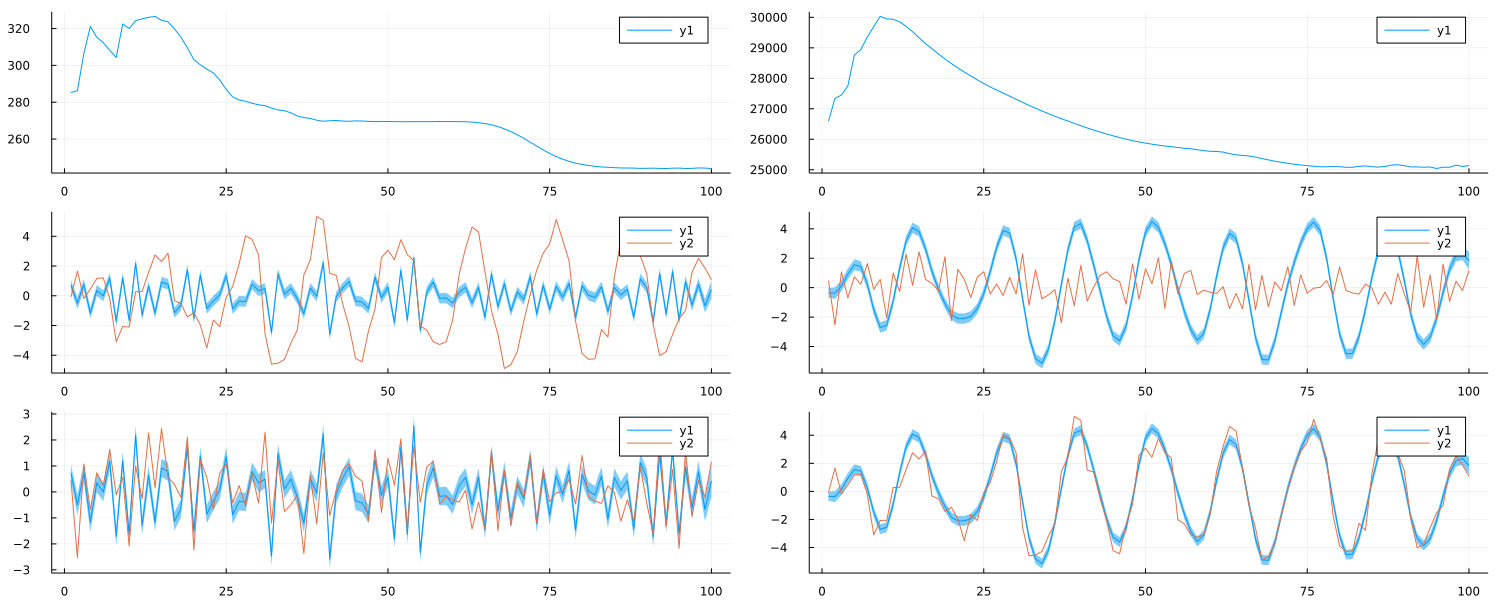

In [501]:
index = 59

p00 = plot(fe[index, :])
p01 = plot(sum(fe, dims=1)')

p1 = plot(rmz[index, :], ribbon=sqrt.(rvz[index, :]))
p1 = plot!(p1, first.(speech_data[index][2]))

p2 = plot(rmx[index, :], ribbon=sqrt.(rvx[index, :]))
p2 = plot!(p2, first.(noise_data[index][2]))

p3 = plot(rmz[index, :], ribbon=sqrt.(rvz[index, :]))
p3 = plot!(p3, first.(noise_data[index][2]))

p4 = plot(rmx[index, :], ribbon=sqrt.(rvx[index, :]))
p4 = plot!(p4, first.(speech_data[index][2]))

plot(p00, p01, p1, p2, p3, p4, layout = @layout([ a b; c d; e f  ]), size = (1500, 600))

### FE for context inference

In [605]:
using Random
Random.seed!(0)

n_datasets = 1000
n_samples = 100
AR_z = 1:4
AR_x = 1:4
variances = [2.0, 1.0, 0.5, 0.3, 0.1]
var_z = rand(variances, n_datasets)
var_x = rand(variances, n_datasets)
data = [[generateAR(n_samples, rand(AR_z),  nvar=var_z[i]) for i in 1:n_datasets], [generateAR(n_samples, rand(AR_x), nvar=var_x[i]) for i in 1:n_datasets]];

In [606]:
# compute free energies of two models (gaussian for silent frame, lar for voiced frame)
active_models = []
active_scenes = []
vmp_iter = 50
ProgressMeter.@showprogress for j in 1:n_datasets
    push!(active_scenes, rand(1:length(data)))
    coefs_1, coefs_2 = data[1][j][1], data[2][j][1]
    observations = first.(data[active_scenes[end]][j][2])
    scene = model_selection(observations, 
                            [lar_inference, lar_inference, lar_inference],
                            [
                                Dict(:mθ => coefs_1, :vθ => diageye(length(coefs_1)), :aτ => 1e12, :bτ => 1.0, :aγ => 1.0, :bγ => var_z[j], :order => length(coefs_1)), 
                                Dict(:mθ => coefs_2, :vθ => diageye(length(coefs_2)), :aτ => 1e12, :bτ => 1.0, :aγ => 1.0, :bγ => var_x[j], :order => length(coefs_2)),
                                Dict(:mθ => zeros(1), :vθ => diageye(1), :aτ => 1e12, :bτ => 1.0, :aγ => 1.0, :bγ => 1.0, :order => 1),
                            ],
                             vmp_iter=vmp_iter)
    push!(active_models, scene)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:31:38


In [616]:
println("Correct: $(n_datasets - mean((active_models .- active_scenes).^2) * n_datasets)")

Correct: 773.0


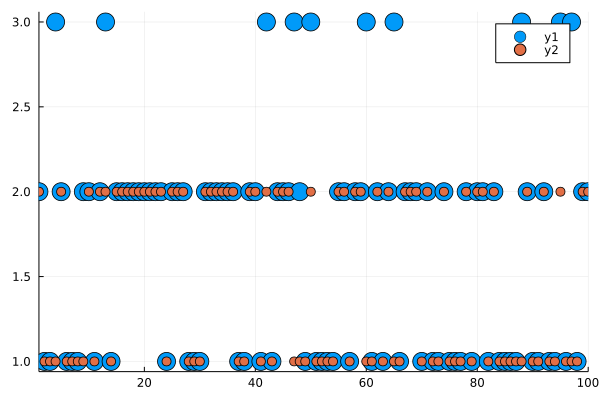

In [611]:
scatter(active_models,markersize=10.0)
scatter!(active_scenes, xlims=(1, 100), markersize=5.0)

### Flow model

In [556]:
function generate_data(nr_samples::Int64)

    # sample weights
    w = rand(nr_samples,2)

    # sample appraisal
    y = zeros(Float64, nr_samples)
    for k = 1:nr_samples
        y[k] = 1.0*(w[k,1] > 0.5)*(w[k,2] < 0.5)
    end

    # return data
    return y, w

end;

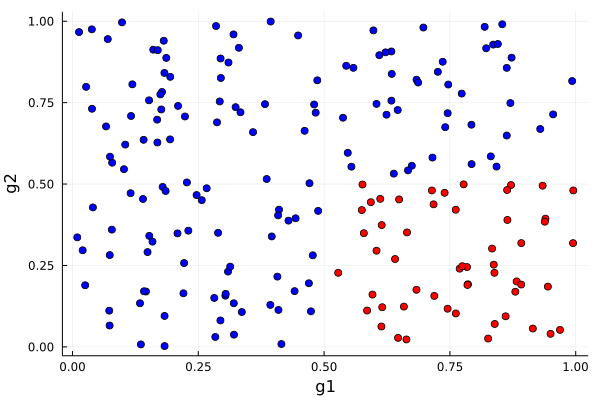

In [557]:
dat_to_col(data) = map(x -> x == 1 ? "red" : "blue", Int64.(round.(data)))
data_y, data_x = generate_data(200);
scatter(data_x[:,1], data_x[:,2], color=dat_to_col(data_y), grid=true, xlabel="g1", ylabel="g2", label=false)

In [558]:
function f(params)
    fe = inference_flow_classifier(Float64.(data_y), [data_x[k,:] for k=1:size(data_x,1)], params)
    return fe
end;

In [559]:
using Optim
res_train = optimize(f, randn(12), LBFGS(), Optim.Options(store_trace = true, show_trace = true, f_tol=1e-6), autodiff=:forward);

Iter     Function value   Gradient norm 
     0     7.751392e+03     3.808230e+03
 * time: 0.0004267692565917969
     1     1.675599e+03     3.515276e+03
 * time: 1.4268028736114502
     2     8.396752e+02     8.812750e+02
 * time: 1.5499048233032227
     3     6.932850e+01     7.941379e+01
 * time: 1.9223699569702148
     4     5.535056e+01     6.770270e+01
 * time: 2.3403308391571045
     5     4.956515e+01     5.102177e+01
 * time: 2.4612338542938232
     6     4.169729e+01     7.170944e+01
 * time: 2.5812339782714844
     7     3.761761e+01     9.138859e+01
 * time: 2.798226833343506
     8     3.206068e+01     2.065752e+02
 * time: 3.0227558612823486
     9     2.793146e+01     9.557985e+01
 * time: 3.414789915084839
    10     2.729350e+01     5.905154e+01
 * time: 3.577547788619995
    11     2.656930e+01     3.951598e+01
 * time: 3.679034948348999
    12     2.595938e+01     6.741467e+01
 * time: 3.8793389797210693
    13     2.499081e+01     9.931009e+00
 * time: 4.03000688552

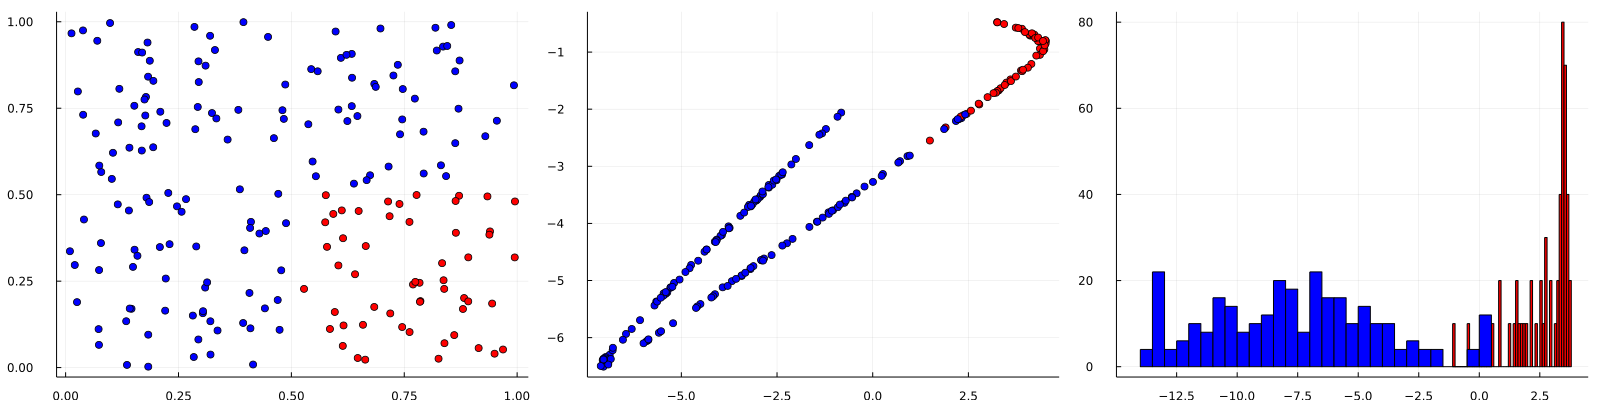

In [560]:
using ImageCore

est_params = Optim.minimizer(res_train)
cmap = colorsigned(color("blue"), color("magenta"), color("red")) ∘ scalesigned(0, 0.5, 1.0)
colors = cmap.(data_y)
inferred_model = deepcopy(compile(model, est_params))
trans_data_x_1 = hcat(map((x) -> forward(inferred_model, x), [data_x[k,:] for k=1:size(data_x,1)])...)'
trans_data_x_2 = map((x) -> dot([1, 1], x), [trans_data_x_1[k,:] for k=1:size(data_x,1)])
trans_data_x_2_split = [trans_data_x_2[data_y .>= 0.5], trans_data_x_2[data_y .<= 0.5]]
plt1 = scatter(data_x[:,1], data_x[:,2], color=colors)
plt2 = scatter(trans_data_x_1[:,1], trans_data_x_1[:,2], color=colors)
hist = histogram(trans_data_x_2_split; stacked=true, normalize=:density, bins=60,  fillcolor=["red" "blue"], label = ["Positive" "Negative"], legend=:topleft)
plot(plt1, plt2, hist, size=(1600, 400), legend=false, layout=(1, 3))